<a href="https://colab.research.google.com/github/raviakasapu/DeepLearningPyTorch/blob/main/Deep_Learning_with_PyTorch_02_Training_Loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Deep Learning with PyTorch - Chapter 02


---
Rethingking the Training Loop


### code examples are from 
https://github.com/dvgodoy/PyTorchStepByStep/blob/master/Chapter02.ipynb

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression

import torch
import torch.optim as optim
import torch.nn as nn

from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')


In [2]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My\ Drive/Colab_files/PyTorchFiles

Mounted at /content/drive/
/content/drive/My Drive/Colab_files/PyTorchFiles


In [3]:
%run -i data_generation/simple_linear_regression.py

In [4]:
%run -i data_preparation/v0.py

In [5]:
%run -i model_configuration/v0.py

In [6]:
%run -i model_training/v0.py

In [7]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9690]], device='cuda:0')), ('0.bias', tensor([1.0235], device='cuda:0'))])


# Higher order functions

# Training step

In [8]:
def make_train_step(model, loss_fn, optimizer):
  def perform_train_step(x,y):
    model.train()
    yhat = model(x)
    loss = loss_fn(yhat,y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss.item()

  return perform_train_step



In [9]:
%%writefile model_configuration/v1.py

device = 'cuda:0'

lr = 0.1
torch.manual_seed(42)

model = nn.Sequential(nn.Linear(1,1)).to(device)

optimizer = optim.SGD(model.parameters(),lr=lr)
loss_fn = nn.MSELoss(reduction='mean')

train_step = make_train_step(model, loss_fn, optimizer)

Overwriting model_configuration/v1.py


In [10]:
%run -i model_configuration/v1.py

In [11]:
train_step

<function __main__.make_train_step.<locals>.perform_train_step>

In [12]:
%%writefile model_training/v1.py

n_epochs = 1000

losses = []

for epoch in range(n_epochs):
  loss = train_step(x_train_tensor, y_train_tensor)
  losses.append(loss)

Overwriting model_training/v1.py


In [13]:
%run -i model_training/v1.py

In [14]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9690]], device='cuda:0')), ('0.bias', tensor([1.0235], device='cuda:0'))])


# building a data set

In [15]:
class CustomDataset(Dataset):
  def __init__(self, x_tensor, y_tensor):
    self.x = x_tensor
    self.y = y_tensor
    
  def __getitem__(self,index):
    return (self.x[index],self.y[index])
  
  def __len__(self):
    return len(self.x)

In [16]:
x_train_tensor = torch.as_tensor(x_train).float()
y_train_tensor = torch.as_tensor(y_train).float()

In [17]:
train_data= CustomDataset(x_train_tensor, y_train_tensor)

In [18]:
print(train_data[0])

(tensor([0.7713]), tensor([2.4745]))


In [19]:
train_data.x.__getitem__(0)

tensor([0.7713])

In [20]:
train_data.__getitem__(0)

(tensor([0.7713]), tensor([2.4745]))

In [21]:
train_data.__len__()

80

# Tensor Dataset

In [22]:
train_data = TensorDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

(tensor([0.7713]), tensor([2.4745]))


# Data Loader

In [23]:
train_loader = DataLoader(
    dataset=train_data,
    batch_size=16,
    shuffle=True
)

In [24]:
next(iter(train_loader))

[tensor([[0.2809],
         [0.3253],
         [0.1560],
         [0.5924],
         [0.0651],
         [0.8872],
         [0.4938],
         [0.0055],
         [0.1409],
         [0.0885],
         [0.1849],
         [0.7290],
         [0.8662],
         [0.3117],
         [0.6842],
         [0.1987]]), tensor([[1.5846],
         [1.8057],
         [1.2901],
         [2.1687],
         [1.1559],
         [2.8708],
         [1.9060],
         [1.0632],
         [1.1211],
         [1.0708],
         [1.5888],
         [2.4927],
         [2.6805],
         [1.7637],
         [2.3492],
         [1.2654]])]

In [25]:
list(train_loader)

[[tensor([[0.7852],
          [0.8022],
          [0.6075],
          [0.1997],
          [0.3309],
          [0.6376],
          [0.4722],
          [0.2809],
          [0.4938],
          [0.5427],
          [0.1560],
          [0.1987],
          [0.3745],
          [0.0885],
          [0.7320],
          [0.8872]]), tensor([[2.5283],
          [2.6229],
          [2.4037],
          [1.3651],
          [1.5427],
          [2.1930],
          [1.9857],
          [1.5846],
          [1.9060],
          [2.2161],
          [1.2901],
          [1.2654],
          [1.7578],
          [1.0708],
          [2.4732],
          [2.8708]])], [tensor([[0.6842],
          [0.0452],
          [0.1159],
          [0.0055],
          [0.3664],
          [0.7751],
          [0.7608],
          [0.7132],
          [0.8631],
          [0.6011],
          [0.1705],
          [0.0344],
          [0.9869],
          [0.0651],
          [0.2921],
          [0.9696]]), tensor([[2.3492],
          [0.9985]

In [26]:
%%writefile data_preparation/v1.py

x_train_tensor = torch.as_tensor(x_train).float()
y_train_tensor = torch.as_tensor(y_train).float()

train_data = TensorDataset(x_train_tensor, y_train_tensor)

train_loader = DataLoader(
    dataset = train_data,
    batch_size = 16,
    shuffle = True
)

Overwriting data_preparation/v1.py


In [27]:
%run -i data_preparation/v1.py

In [28]:
%run -i model_configuration/v1.py

In [29]:
%%writefile model_training/v2.py

n_epochs = 1000
losses = []

for epoch in range(n_epochs):
  mini_batch_losses = []

  for x_batch, y_batch in train_loader:
    x_batch = x_batch.to('cuda:0')
    y_batch = y_batch.to('cuda:0')

    mini_batch_loss = train_step(x_batch, y_batch)
    mini_batch_losses.append(mini_batch_loss)
  
  loss = np.mean(mini_batch_losses)
  losses.append(loss)

Overwriting model_training/v2.py


In [30]:
%run -i model_training/v2.py

In [31]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9696]], device='cuda:0')), ('0.bias', tensor([1.0243], device='cuda:0'))])


In [45]:
def mini_batch(device, data_loader, step):
  mini_batch_losses = []

  for x_batch, y_batch in data_loader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    mini_batch_loss = step(x_batch, y_batch)
    mini_batch_losses.append(mini_batch_loss)
  
  loss = np.mean(mini_batch_losses)
  return loss

In [33]:
%%writefile model_training/v3.py

n_epochs = 200

losses = []

for epoch in range(n_epochs):
  loss = mini_batch(device, train_loader, train_step)
  losses.append(loss)

Overwriting model_training/v3.py


In [34]:
%run -i model_training/v3.py

In [35]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9696]], device='cuda:0')), ('0.bias', tensor([1.0260], device='cuda:0'))])


# Random split

In [36]:
%%writefile data_preparation/v2.py

torch.manual_seed(42)

x_tensor = torch.as_tensor(x).float()
y_tensor = torch.as_tensor(y).float()

dataset = TensorDataset(x_tensor, y_tensor)

ratio = 0.8

n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train

train_data, val_data = random_split(dataset, [n_train, n_val])

train_loader = DataLoader(
    dataset = train_data,
    batch_size = 16,
    shuffle = True
)

val_loader = DataLoader(
    dataset = val_data, 
    batch_size = 16
)


Writing data_preparation/v2.py


In [37]:
%run -i data_preparation/v2.py

### make val step

In [38]:
def make_val_step(model, loss_fn):
  def perform_val_step(x,y):
    model.eval()

    yhat = model(x)
    loss = loss_fn(yhat,y)

    return loss.item()
  return perform_val_step

In [51]:
%%writefile model_configuration/v2.py

device = 'cuda:0'

lr=0.1
torch.manual_seed(42)

model = nn.Sequential(nn.Linear(1,1)).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.MSELoss(reduction='mean')

train_step = make_train_step(model, loss_fn, optimizer)
val_step = make_val_step(model, loss_fn)

Overwriting model_configuration/v2.py


In [52]:
%run -i model_configuration/v2.py

In [49]:
%%writefile model_training/v4.py

device = 'cuda:0'
n_epochs = 200

losses = []
val_losses = []

for epoch in range(n_epochs):
  loss = mini_batch(device, train_loader, train_step)
  losses.append(loss)

  with torch.no_grad():
    val_loss = mini_batch(device, val_loader, val_step)
    val_losses.append(val_loss)

Overwriting model_training/v4.py


In [53]:
%run -i model_training/v4.py

In [54]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9599]], device='cuda:0')), ('0.bias', tensor([1.0151], device='cuda:0'))])


In [ ]:
def plot_losses(losses, val_losses):
    fig = plt.figure(figsize=(10, 4))
    plt.plot(losses, label='Training Loss', c='b')
    plt.plot(val_losses, label='Validation Loss', c='r')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    return fig

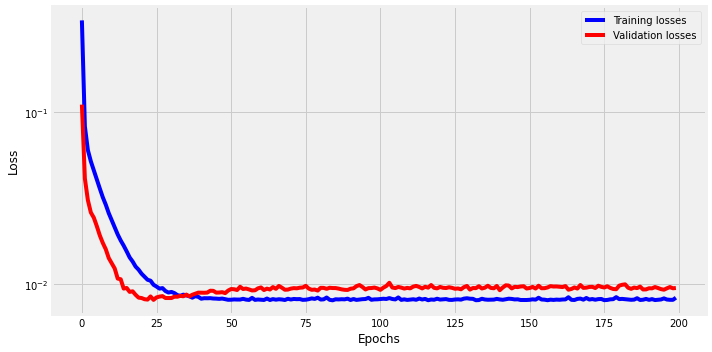

In [58]:
fig = plt.figure(figsize= (10,5))
plt.plot(losses, label='Training losses',c='b')
plt.plot(val_losses, label='Validation losses',c='r')

plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()

### running all together

In [59]:
%run -i data_preparation/v2.py
%run -i model_configuration/v2.py
%run -i model_training/v4.py

<Figure size 432x288 with 0 Axes>

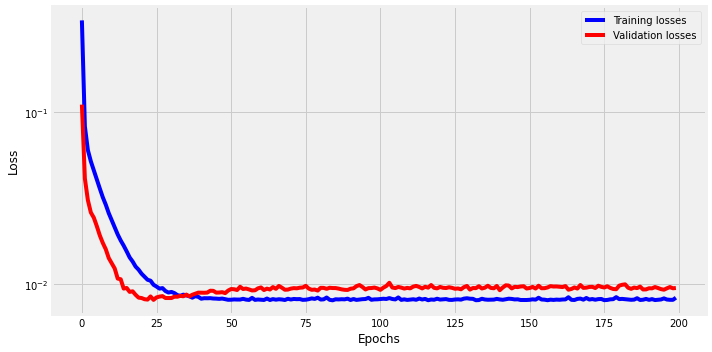

In [60]:
fig = plt.figure(figsize= (10,5))
plt.plot(losses, label='Training losses',c='b')
plt.plot(val_losses, label='Validation losses',c='r')

plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()

# Tensor Board